The goal of this notebook is to calculate the number of COSMIC genes that are affected in each individual using the guides in the Avana library

In [16]:
#Set up the environment
library(tidyverse)
library(reshape2)

In [17]:
#Load in the cosmic cancer gene census genes
setwd("/home/jupyter/Ancestry/analysis/cosmic_cancer_gene_census")
cosmic.genes = read.table("cosmic_genes.csv", sep = ",", header = T)

cosmic.tier1 = cosmic.genes %>% 
filter(Tier %in% "1") %>%
filter(Role.in.Cancer %in% c("oncogene", "TSG")) %>%
pull(Gene.Symbol)

In [18]:
#Load in the gnomAD annotation file so that we know which sample belongs to each ancestry group
setwd("/home/jupyter/Ancestry/raw_data/hgdp")
sample.annotation = read.table("gnomad.genomes.v3.1.2.hgdp_1kg_subset_sample_meta.tsv.bgz", sep = "\t", header = T) %>%
select(s, gnomad_population_inference) %>%
mutate(gnomad_population_inference = gsub("\\..*pop", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("prob..*", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub("..*:", "", gnomad_population_inference)) %>%
mutate(gnomad_population_inference = gsub(",", "", gnomad_population_inference)) %>%
rename("sample" = 1, "ancestry" = 2)

head(sample.annotation)

,sample,ancestry
,<chr>,<chr>
1,CHMI_CHMI3_WGS2,nfe
2,HG00096,nfe
3,HG00097,nfe
4,HG00099,nfe
5,HG00100,nfe
6,HG00101,nfe


In [19]:
#Load in the avana SNP/guide matrix
setwd("/home/jupyter/Ancestry/analysis/cosmic_cancer_gene_census")
avana.matrix = read.table("final_avana.txt", sep = "\t", header = T)

head(avana.matrix)

,seq,chr,posL,posR,CHMI_CHMI3_WGS2,LP6005441.DNA_F08,HGDP00843,HGDP00392,LP6005441.DNA_H03,HGDP00544,⋯,HG00288,HG00290,HG00304,HG01765,HG01766,HG01767,HG01768,HG01785,HG01786,HG02219
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,AAATCCCCCTGAAGGTACCG,chr22,46626903,46626925,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,AACAAGAAGGAGATTCAGAA,chr22,16991998,16992020,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AACACCGGTGAGGTATATCG,chr22,24557741,24557763,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AACCAGCAGCGCAAAAACGG,chr22,31345490,31345512,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AACCCGGACGAGGACCCGCG,chr22,31291036,31291058,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,AACGGCATATGCGGCCACGA,chr22,30532670,30532692,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [20]:
#Load in the guide-to-gene mapping file
setwd("/home/jupyter/Ancestry/analysis/cosmic_cancer_gene_census")
guide.to.gene = read.table("internal-21q4_v9-achilles-guide-map.csv", sep = ",", header = T) %>%
mutate(gene = word(gene, 1)) %>%
select(sgrna, gene) %>%
rename("seq" = sgrna)

head(guide.to.gene)

,seq,gene
,<chr>,<chr>
1,AAAAAAATCCAGCAATGCAG,SHOC2
2,AAAAAACCCGTAGATAGCCT,NDUFA12
3,AAAAAAGAAGAAAAAACCAG,SDAD1
4,AAAAAAGCTCAAGAAGGAGG,FAM98A
5,AAAAAAGGCTGTAAAAGCGT,ZNF253
6,AAAAAAGGGCTCCAAAAAGG,H2BC7


In [21]:
#Filter the SNP matrix so that it only includes the cosmic tier1 genes
cosmic.tier1.matrix = avana.matrix %>% 
mutate(seq = plyr::mapvalues(from = guide.to.gene$seq, to = guide.to.gene$gene, seq, warn_missing = FALSE)) %>%
select(-chr, -posL, -posR) %>%
filter(seq %in% all_of(cosmic.tier1)) %>%
melt() %>%
group_by(seq, variable) %>%
summarise(sum(value)) %>%
rename("value" = 3) %>%
dcast(formula = seq ~ variable, fill = "value")

head(cosmic.tier1.matrix)
dim(cosmic.tier1.matrix)


Using seq as id variables

`summarise()` has grouped output by 'seq'. You can override using the `.groups`
argument.


,seq,CHMI_CHMI3_WGS2,LP6005441.DNA_F08,HGDP00843,HGDP00392,LP6005441.DNA_H03,HGDP00544,HGDP01053,HGDP00191,HGDP01399,⋯,HG00288,HG00290,HG00304,HG01765,HG01766,HG01767,HG01768,HG01785,HG01786,HG02219
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ACVR1,1,1,1,1,1,1,1,2,1,⋯,1,1,1,1,1,1,1,1,1,1
2,ACVR1B,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,ACVR2A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AKT1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AKT2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,APC,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1]  209 4152

In [22]:
#Now create a data frame that has the number of affected cosmic genes per individual
affected.genes.per.person = cosmic.tier1.matrix %>%
select(-seq) %>%
apply(2, as.numeric) %>%
apply(2, sum) %>%
data.frame() %>%
rename("num_genes" = 1) %>%
tibble::rownames_to_column("sample") %>%
inner_join(sample.annotation, by = "sample") %>%
filter(ancestry != "NA") %>%
mutate(ancestry = gsub("nfe", "Other", ancestry)) %>%
mutate(ancestry = gsub("amr", "Other", ancestry)) %>%
mutate(ancestry = gsub("sas", "Other", ancestry)) %>%
mutate(ancestry = gsub("oth", "Other", ancestry)) %>%
mutate(ancestry = gsub("eas", "Other", ancestry)) %>%
mutate(ancestry = gsub("afr", "African", ancestry)) %>%
mutate(ancestry = gsub("mid", "Other", ancestry)) %>%
mutate(ancestry = gsub("fin", "Other", ancestry))


head(affected.genes.per.person)
str(affected.genes.per.person)

,sample,num_genes,ancestry
,<chr>,<dbl>,<chr>
1,CHMI_CHMI3_WGS2,14,Other
2,HGDP00843,10,Other
3,HGDP00392,10,Other
4,HGDP00544,8,Other
5,HGDP01053,9,Other
6,HGDP00191,10,Other


'data.frame':	4010 obs. of  3 variables:
 $ sample   : chr  "CHMI_CHMI3_WGS2" "HGDP00843" "HGDP00392" "HGDP00544" ...
 $ num_genes: num  14 10 10 8 9 10 7 8 9 10 ...
 $ ancestry : chr  "Other" "Other" "Other" "Other" ...


In [23]:
#Calculate the minimum, maximum, and median number of affected genes per person
min.num.genes = affected.genes.per.person %>%
pull(num_genes) %>%
min()

max.num.genes = affected.genes.per.person %>%
pull(num_genes) %>%
max()

median.num.genes = affected.genes.per.person %>%
pull(num_genes) %>%
median()

min.num.genes
max.num.genes
median.num.genes

[1] 2

[1] 19

[1] 10

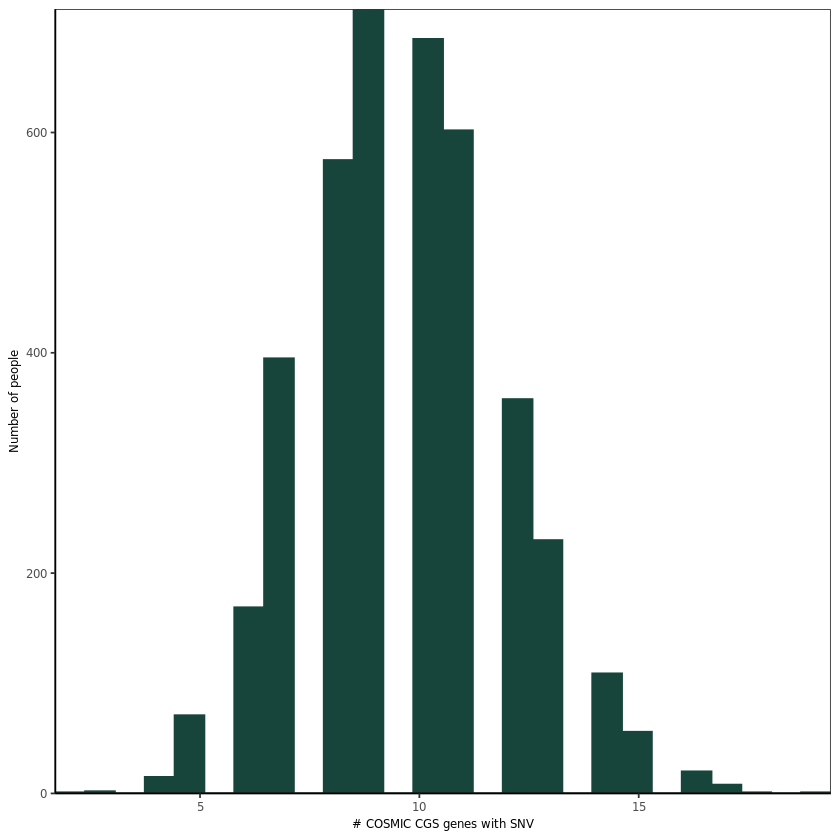

In [24]:
#Now plot the plot!
affected.genes.per.person %>%
ggplot(aes(x = num_genes)) +
geom_histogram(bins = 26, color = rgb(24, 69, 59, maxColorValue = 255), fill = rgb(24, 69, 59, maxColorValue = 255)) +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 7),
axis.title.y = element_text(color = "black", size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

scale_y_continuous(expand = c(0,0)) +
scale_x_continuous(expand = c(0,0)) +

ylab("Number of people") +
xlab("# COSMIC CGS genes with SNV")


setwd("/home/jupyter/Ancestry/analysis/cosmic_cancer_gene_census")
ggsave("affected_cosmic_genes.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/cosmic_cancer_gene_census
gsutil cp affected_cosmic_genes.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Pick any two samples from the top and fill in their information on the figure

# Calculate pairwise overlaps in COSMIC tier 1 genes

Do this for only 25 random samples from each subpopulation

In [14]:
#Get vectors for all of the samples that we want.
set.seed(42)
random.nfe.samples = sample.annotation %>% filter(ancestry %in% "nfe") %>% sample_n(25)
random.fin.samples = sample.annotation %>% filter(ancestry %in% "fin") %>% sample_n(25)
random.eas.samples = sample.annotation %>% filter(ancestry %in% "eas") %>% sample_n(25) 
random.amr.samples = sample.annotation %>% filter(ancestry %in% "amr") %>% sample_n(25)
random.sas.samples = sample.annotation %>% filter(ancestry %in% "sas") %>% sample_n(25) 
random.mid.samples = sample.annotation %>% filter(ancestry %in% "mid") %>% sample_n(25)

#bind all of the datasets together
selected.samples = rbind(random.nfe.samples, random.fin.samples, random.eas.samples, random.amr.samples, random.sas.samples, random.mid.samples)

In [15]:
#Filter the genotyping data to only include the selected samples
selected.cosmic.matrix = cosmic.tier1.matrix %>%
rename_all(~gsub("\\.", "-", .)) %>%
select(seq, all_of(selected.samples$sample)) %>%
mutate(across(-seq, ~ ifelse(. > 1, 1, .))) %>%
rename("gene" = seq)

selected.cosmic.matrix %>% head()

,gene,NA12828,HGDP01062,HG01626,HG00253,HG01786,HG01619,NA20764,HG00150,HG01601,⋯,HGDP00568,HGDP00649,HGDP00601,HGDP00615,HGDP01272,HGDP00562,HGDP00612,HGDP00699,HGDP01280,HGDP01268
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ACVR1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
2,ACVR1B,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,ACVR2A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AKT1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AKT2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,APC,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [16]:
#Go through all of the cell lines and get a dataframe that has which genes are affected in each cell line
affected.gene.list = selected.cosmic.matrix %>% 
melt(id = "gene") %>%
filter(value %in% "1") %>%
select(-value) %>%
rename("sample" = variable)

In [17]:
#Get a vector of all unique samples
unique.samples = affected.gene.list %>%
pull(sample) %>%
unique() %>%
as.character()

In [18]:
#Now loop through everything and compute an intersection matrix
intersection.matrix = NULL
for(line in unique.samples){
    
    affected.gene.v1 = affected.gene.list %>% filter(sample %in% all_of(line)) %>% pull(gene) %>% unique()
    
    intersection.vector = NULL
    for(i in 1:length(unique.samples)){
        
        #Extract a vector of affected genes
        second.line.of.interest = unique.samples[i]
        affected.gene.vi = affected.gene.list %>% filter(sample %in% all_of(second.line.of.interest)) %>% pull(gene) %>% unique()
        
        #Calculate the intersection length
        intersection.length = intersect(affected.gene.v1, affected.gene.vi) %>% length()
        
        #Export it outside of the loop
        intersection.vector[i] = intersection.length    
    }
    
    #Now export the final vector to outside of the loop and store it as a df
    intersection.matrix = cbind(intersection.matrix, intersection.vector)
    
}

#Rename the matrix
colnames(intersection.matrix) = unique.samples
intersection.matrix = intersection.matrix %>%
data.frame() %>%
mutate("sample" = unique.samples, .before = 1)

This is probably not the correct strategy. Maybe just do the propaganda figure.


The goal this time is to pick 5 samples from each ancestry group, then filter so that it only includes the affected genes and make a heatmap. Maybe that will be good enough.

In [19]:
#Randomly select samples
set.seed(42)
random.nfe.propaganda.samples = sample.annotation %>% filter(ancestry %in% "nfe") %>% sample_n(5)
random.fin.propaganda.samples = sample.annotation %>% filter(ancestry %in% "fin") %>% sample_n(5)
random.eas.propaganda.samples = sample.annotation %>% filter(ancestry %in% "eas") %>% sample_n(5) 
random.amr.propaganda.samples = sample.annotation %>% filter(ancestry %in% "amr") %>% sample_n(5)
random.sas.propaganda.samples = sample.annotation %>% filter(ancestry %in% "sas") %>% sample_n(5) 
random.mid.propaganda.samples = sample.annotation %>% filter(ancestry %in% "mid") %>% sample_n(5)
random.afr.propaganda.samples = sample.annotation %>% filter(ancestry %in% "afr") %>% sample_n(5)

#bind all of the datasets together
selected.propaganda.samples = rbind(random.nfe.propaganda.samples, random.fin.propaganda.samples, random.eas.propaganda.samples, random.amr.propaganda.samples, random.sas.propaganda.samples, random.mid.propaganda.samples, random.afr.propaganda.samples)

In [20]:
#Filter the genotyping data to only include the selected propaganda samples
selected.propaganda.cosmic.matrix = cosmic.tier1.matrix %>%
rename_all(~gsub("\\.", "-", .)) %>%
select(seq, all_of(selected.propaganda.samples$sample)) %>%
mutate(across(-seq, ~ ifelse(. > 1, 1, .))) %>%
rename("gene" = seq)

selected.propaganda.cosmic.matrix %>% head()

,gene,NA12828,HGDP01062,HG01626,HG00253,HG01786,HG00267,HG00325,HG00323,HG00274,⋯,HGDP00604,HGDP00626,HGDP00581,HGDP00590,HGDP00651,LP6005443-DNA_F02,HG02983,NA19238,NA20342,HG02594
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ACVR1,1,1,1,1,1,1,1,1,1,⋯,1,0,1,1,1,0,0,1,1,0
2,ACVR1B,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,ACVR2A,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,AKT1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AKT2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,APC,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [38]:
#Calculate the row order
factor.order.df = selected.propaganda.cosmic.matrix %>%
mutate_at(vars(-gene), as.numeric) %>%
filter(rowSums(select(., -gene)) != 0) %>%
melt(id = "gene") %>%
rename("sample" = variable) %>%
mutate("ancestry" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$ancestry, sample, warn_missing = FALSE)) %>%
group_by(gene) %>%
summarise("total_affected" = sum(value)) %>%
arrange(total_affected)

#Calculate the total number of affected cells per ancestry group
total.affected.cells.df = selected.propaganda.cosmic.matrix %>%
mutate_at(vars(-gene), as.numeric) %>%
filter(rowSums(select(., -gene)) != 0) %>%
melt(id = "gene") %>%
rename("sample" = variable) %>%
mutate("ancestry" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$ancestry, sample, warn_missing = FALSE)) %>%
group_by(ancestry) %>%
summarise("total_affected_cells" = sum(value))

total.affected.cells.df

ancestry,total_affected_cells
<fct>,<dbl>
nfe,47
fin,45
eas,43
amr,49
sas,44
mid,44
afr,55


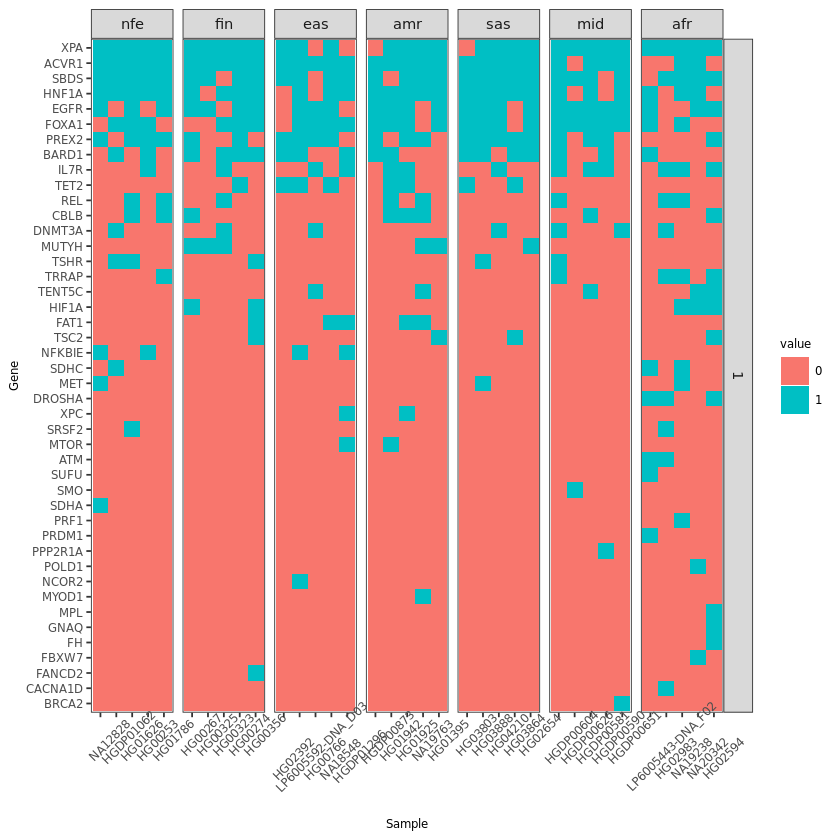

In [30]:
#Create the propaganda heatmap
selected.propaganda.cosmic.matrix %>%
mutate(gene = factor(gene, levels = factor.order.df$gene)) %>%
mutate_at(vars(-gene), as.numeric) %>%
filter(rowSums(select(., -gene)) != 0) %>%
melt(id = "gene") %>%
rename("sample" = variable) %>%
mutate("ancestry" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$ancestry, sample, warn_missing = FALSE)) %>%
mutate(value = as.character(value)) %>%
ggplot(aes(x = sample, y = gene, fill = value)) +
geom_tile() +
facet_grid(1 ~ ancestry, scale = "free") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text = element_text(size = 7),
axis.title = element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

ylab("Gene") +
xlab("Sample") +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.25)
)


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/cosmic_cancer_gene_census')
ggsave("propaganda_heatmap.pdf", width = 6, height = 8)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/cosmic_cancer_gene_census
gsutil cp propaganda_heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))